# CAFA 5 protein function Prediction with TensorFlow

In this notebook we trained a simple DNN model that predicts the function of the protein i.e., **GO term ID** using it's amino acid sequences.

In [1]:
!pip install obonet
!pip install pyvis
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.6 MB/s eta 0:00:00


## About the Dataset

### Protein Sequence

Each protein is composed of dozens or hundreds of amino acids that are linked sequentially. Each amino acid in the sequence may be represented by a one-letter or three-letter code. Thus the sequence of a protein is often notated as a string of letters.

# Gene Ontology

The functional properties of a proteins are defined by Gene Ontology(GO). Gene Ontology (GO) describes our understanding of the biological domain with respect to three aspects:
1. Molecular Function (MF)
2. Biological Process (BP)
3. Cellular Component (CC)

[Source](http://geneontology.org/docs/ontology-documentation).

# Dataset description

`train_sequences.fasta` :  contains the sequences for proteins with annotations (labelled proteins).

`train_terms.tsv` :  contains the list of annotated terms (ground truth) for the proteins in `train_sequences.fasta`. 

In `train_terms.tsv` the first column indicates the protein's UniProt accession ID (unique protein id), the second is the `GO Term ID`, and the third indicates in which ontology the term appears.

# Labels of the dataset

The objective of our model is to predict the terms (functions) of a protein sequence. One protein sequence can have many functions and can thus be classified into any number of terms. Each term is uniquely identified by a `GO Term ID`. Thus our model has to predict all the `GO Term ID`s for a protein sequence. Hence this is a multi-label classification problem.

# Protein embeddings for train and test data

To train a machine learning model we cannot use the alphabetical protein sequences in`train_sequences.fasta` directly. They have to be converted into a vector format. Hence we've converted the alphabetical protein sequences into numerical vector embeddings first and then train the model.

Protein sequences can be converted to vector embeddings using T5Tokenizer and T5Encoder from transformers available on hugging face. This results in a vector embedding of length 1024

# Import the Required Libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import progressbar

2024-04-08 07:02:24.737503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 07:02:24.737634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 07:02:24.871890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Read the data

In [3]:
train_terms=pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv', sep="\t")
train_terms.head()
train_terms.shape

(5363863, 3)

# Calculating protein embeddings

The folllowing code extracts the protein sequence from fasta file and extract embeddings of it using T5Tokenizer and T5Encoder imported from transformers. Each embedding is a vector of length 1024.

In [4]:
import os
import json
from typing import Dict
from collections import Counter

import random
import obonet
import pandas as pd
import numpy as np
from Bio import SeqIO
import re
from transformers import T5Tokenizer, T5EncoderModel
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False) #.to(device)

# Load the model
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)

def get_embeddings(seq):
    sequence_examples = [" ".join(list(re.sub(r"[UZOB]", "X", seq)))]

    ids = tokenizer.batch_encode_plus(sequence_examples, add_special_tokens=True, padding="longest")

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    # generate embeddings
    with torch.no_grad():
        embedding_repr = model(input_ids=input_ids,
                               attention_mask=attention_mask)

    # extract residue embeddings for the first ([0,:]) sequence in the batch and remove padded & special tokens ([0,:7]) 
    emb_0 = embedding_repr.last_hidden_state[0]
    emb_0_per_protein = emb_0.mean(dim=0)
    
    return emb_0_per_protein

file = '/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta'
sequences = SeqIO.parse(file, "fasta")
print(next(iter(sequences)).seq)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLKQPLRNKRVCVCGIDPYPKDGTGVPFESPNFTKKSIKEIASSISRLTGVIDYKGYNLNIIDGVIPWNYYLSCKLGETKSHAIYWDKISKLLLQHITKHVSVLYCLGKTDFSNIRAKLESPVTTIVGYHPAARDRQFEKDRSFEIINVLLELDNKVPINWAQGFIY


In [5]:
sequences = SeqIO.parse(file, "fasta")
get_embeddings(str(next(iter(sequences)).seq))

tensor([ 0.0495, -0.0329,  0.0325,  ..., -0.0435,  0.0965,  0.0731],
       device='cuda:0')

# Loading the protein embeddings


We can calculate the protein embeddings on our own, but the kaggle resources are not enough to collect embeddings for all the sequences in train dataset. So we are using the pre-calculated protein embeddings done by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

If the `t5embeds` is not yet added to the input data of the notebook, it can be added by clicking on `Add Data` and search for `t5embeds` and then click on the `+` beside it.

The protein embeddings to be used for training are recorded in `train_embeds.npy` and the corresponding protein ids are available in `train_ids.npy`.

We will load the protein ids of the protein embeddings in the train dataset contained in `train_ids.npy` into a numpy array.

In [6]:
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
train_protein_ids_pd=pd.DataFrame(train_protein_ids)
train_protein_ids_pd.head(100)

,0
0,P20536
1,O73864
2,O95231
3,A0A0B4J1F4
4,P54366
...,...
95,A0A193H396
96,P57075
97,O22779
98,P57790


<!-- Now, we will load`train_embeds.py` which contains the pre-calculated embeddings of the proteins in the train dataset. with protein_ids (`id`s we loaded previously from the **train_ids.npy**) into a numpy array. This array now contains the precalculated embeddings for the protein_ids( Ids we loaded above from **train_ids.npy**) needed for training. -->

After loading the files as numpy arrays, we will convert them into Pandas dataframe.

Each protein embedding is a vector of length 1024. We create the resulting dataframe such that there are 1024 columns to represent the values in each of the 1024 places in the vector.

In [7]:
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')
column_num = train_embeddings.shape[1]
train_df  = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
train_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


# Prepare the dataset

There are more than 40,000 labels in the `train_terms.tsv` file, so to simplify we will choose the most frequent 1500 `GO term IDs` as labels of the dataset.

In [8]:
# Extracting Go IDs
num_of_labels = 1500
labels = train_terms['term'].value_counts().index
labels=labels[:num_of_labels]
labels

Index(['GO:0005575', 'GO:0008150', 'GO:0110165', 'GO:0003674', 'GO:0005622',
       'GO:0009987', 'GO:0043226', 'GO:0043229', 'GO:0005488', 'GO:0043227',
       ...
       'GO:0031345', 'GO:0140053', 'GO:0034250', 'GO:0098802', 'GO:0045861',
       'GO:0001818', 'GO:0031674', 'GO:0051783', 'GO:0070828', 'GO:0016887'],
      dtype='object', name='term', length=1500)

In [9]:
# Extracting the dataset which contains the top 1500(labels) GO terms
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]
train_terms_updated=train_terms_updated.reset_index(drop=True)
train_terms_updated

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0044270,BPO
3,A0A009IHW8,GO:0006753,BPO
4,A0A009IHW8,GO:0044237,BPO
...,...,...,...
4420732,X5L565,GO:0003674,MFO
4420733,X5L565,GO:0016491,MFO
4420734,X5M5N0,GO:0005515,MFO
4420735,X5M5N0,GO:0005488,MFO


Plot the most frequent 100 `GO Term ID`s in `train_terms.tsv`.

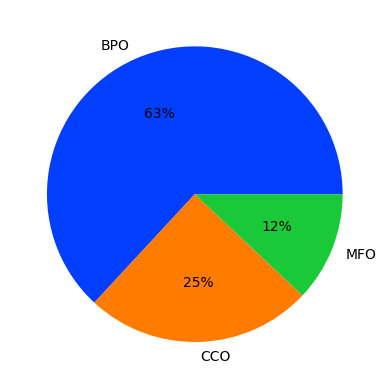

In [10]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

As evident from the pie chart above, majority of the `GO term Id`s have their aspect as BPO(Biological Process Ontology). In the labels array, absence or presence of each `GO term Id` is denoted by 0 or 1.

Uncomment the next 2 cells if labels are not already available in the datasets directory

In [11]:
# train_size = train_protein_ids.shape[0]
# train_labels = np.zeros((train_size ,num_of_labels))
# series_train_protein_ids = pd.Series(train_protein_ids)

# bar = progressbar.ProgressBar(maxval=num_of_labels, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
# for i in range(num_of_labels):
#     n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
#     label_related_proteins = n_train_terms['EntryID'].unique()
#     train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
#     bar.update(i+1)
# bar.finish()

# labels_df = pd.DataFrame(data = train_labels, columns = labels)
# print(labels_df.shape)

`label_df` is composed of 1500 columns and 142246 entries.

In [12]:
# #!mkdir /kaggle/working/labels
# labels_df = pd.DataFrame(data = train_labels, columns = labels)
# labels_df.to_csv('/kaggle/working/labels/kaggledata.csv')

Run the next cell only if labels are already available in the datasets directory

In [13]:
labels_df=pd.read_csv('/kaggle/input/labels/kaggledata.csv')
labels_df=labels_df.drop(columns='Unnamed: 0')

In [14]:
labels_df.shape

(142246, 1500)

In [15]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0031345,GO:0140053,GO:0034250,GO:0098802,GO:0045861,GO:0001818,GO:0031674,GO:0051783,GO:0070828,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training

We will use Tensorflow to train a Deep Neural Network with the protein embeddings to perform mult-label classification.

In [16]:
train_df.shape

(142246, 1024)

In [17]:
labels_df.shape

(142246, 1500)

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_df, labels_df, test_size=0.2, random_state=42)

# Define model architecture
INPUT_SHAPE = [train_df.shape[1]]
num_of_labels = labels_df.shape[1]

BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=num_of_labels, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()]
)

# Train the model with validation split
history = model.fit(
    train_data,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_data, val_labels)
)

# Get the final training and validation metrics
final_train_metrics = model.evaluate(train_data, train_labels)
final_val_metrics = model.evaluate(val_data, val_labels)

print("Final Training Metrics:")
print("Loss:", final_train_metrics[0])
print("Binary Accuracy:", final_train_metrics[2])
print("AUC:", final_train_metrics[1])

print("\nFinal Validation Metrics:")
print("Loss:", final_val_metrics[0])
print("Binary Accuracy:", final_val_metrics[2])
print("AUC:", final_val_metrics[1])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
 3/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - auc: 0.5239 - binary_accuracy: 0.5772 - loss: 0.6757

I0000 00:00:1712559857.148531      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712559857.166060      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - auc: 0.5845 - binary_accuracy: 0.8345 - loss: 0.3769

W0000 00:00:1712559863.215756      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 409ms/step - auc: 0.5875 - binary_accuracy: 0.8383 - loss: 0.3703 - val_auc: 0.8390 - val_binary_accuracy: 0.9800 - val_loss: 0.5725
Epoch 2/20
 1/23 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - auc: 0.8242 - binary_accuracy: 0.9795 - loss: 0.0906

W0000 00:00:1712559866.178083      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.8111 - binary_accuracy: 0.9796 - loss: 0.0855 - val_auc: 0.8335 - val_binary_accuracy: 0.9801 - val_loss: 0.5435
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - auc: 0.8282 - binary_accuracy: 0.9798 - loss: 0.0787 - val_auc: 0.8480 - val_binary_accuracy: 0.9801 - val_loss: 0.5261
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - auc: 0.8439 - binary_accuracy: 0.9800 - loss: 0.0765 - val_auc: 0.8602 - val_binary_accuracy: 0.9803 - val_loss: 0.5107
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - auc: 0.8581 - binary_accuracy: 0.9801 - loss: 0.0741 - val_auc: 0.8820 - val_binary_accuracy: 0.9805 - val_loss: 0.4892
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - auc: 0.8756 - binary_accuracy: 0.9802 - loss: 0.0715 - val_auc: 0.8974 - val_binary_accuracy: 0.9805 - val_loss: 0.4650
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - auc: 0.8878 - binary_accuracy: 0.9803 - loss: 0.0697 - val_auc: 0.9057 - val_binary_accuracy:

W0000 00:00:1712559894.910882      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3557/3557 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - auc: 0.9459 - binary_accuracy: 0.9816 - loss: 0.1323


W0000 00:00:1712559901.294559      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.9370 - binary_accuracy: 0.9812 - loss: 0.1336
Final Training Metrics:
Loss: 0.13216589391231537
Binary Accuracy: 0.9816933274269104
AUC: 0.9459705948829651

Final Validation Metrics:
Loss: 0.13321349024772644
Binary Accuracy: 0.9812984466552734
AUC: 0.9374620914459229


W0000 00:00:1712559904.635608      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [19]:
model.save("/kaggle/working/model.weights.h5")

In [20]:
model=tf.keras.models.load_weights("/kaggle/working/model.weights.h5")

AttributeError: module 'keras.models' has no attribute 'load_weights'

In [ ]:
final_train_metrics = model.evaluate(train_data, train_labels)
final_val_metrics = model.evaluate(val_data, val_labels)

print("Final Training Metrics:")
print("Loss:", final_train_metrics[0])
print("Binary Accuracy:", final_train_metrics[1])
print("AUC:", final_train_metrics[2])

print("\nFinal Validation Metrics:")
print("Loss:", final_val_metrics[0])
print("Binary Accuracy:", final_val_metrics[1])
print("AUC:", final_val_metrics[2])


In [ ]:
custom_input_tensor = np.array([[1 for i in range(1024)]])
print(custom_input_tensor)
print(len(custom_input_tensor[0]))
# Get predictions for custom input tensor
predictions = model.predict(custom_input_tensor)

# 'predictions' will contain the model's output for the custom input tensor
print(predictions)
for i in predictions[0]:
    x=0 if i<0.5 else 1
    print(x)
# print(len(predictions))


# Plot the model's loss and accuracy for each epoch

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

# Submission

For submission we will use the protein embeddings of the test data created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

In [ ]:
# test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')
# column_num = test_embeddings.shape[1]
# test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
# test_df

In [ ]:
# from tensorflow.keras.models import load_model
# model=load_model('/kaggle/working/model/model_1.h5')
# predictions =  model.predict(test_df)

In [ ]:
# import pickle
# file_path = '/kaggle/working/predictions'
# with open(file_path, 'wb') as file:
#     pickle.dump(predictions, file)

In [ ]:
# import tensorflow as tf
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# import progressbar

In [ ]:
# train_terms=pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv', sep="\t")
# num_of_labels = 1500
# labels = train_terms['term'].value_counts().index
# labels=labels[:num_of_labels]
# labels

In [ ]:
# import pickle
# file_path = '/kaggle/working/predictions'
# with open(file_path, 'rb') as file:
#     predictions = pickle.load(file)

In [ ]:
# predictions.shape

In [ ]:
# import pandas as pd
# import numpy as np

# test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
# num_predictions = predictions.shape[1]
# num_labels = predictions.shape[0]

# data = {
#     'Protein Id': pd.Series(np.repeat(test_protein_ids, num_predictions)),
#     'GO Term Id': pd.Series(np.tile(labels, num_predictions)),
#     'Prediction': pd.Series(predictions.ravel())
# }

# df_submission = pd.DataFrame(data)
# df_submission.to_csv("submission.tsv",sep="\t")


From the predictions we will create the submission data frame.

**Note**: This will take atleast **15 to 20** minutes to finish.

In [ ]:
# predictions.ravel()

In [ ]:
# df_submission